In [1]:
# if str(get_ipython()).startswith('<google.colab.'):
#     !pip install gymnasium
#     !pip install pybullet
#     !git clone https://github.com/bulletphysics/bullet3.git


In [2]:
import random

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import RecordVideo
import pybullet
import pybullet_data

from PIL import Image
# from google.colab import drive
# drive.mount('/content/drive')

from torch import nn, optim
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

from IPython.display import HTML

from tqdm import tqdm

pybullet build time: Nov 28 2023 23:45:17


# Hyper parameter settings

In [3]:
ENV = "myEnv-v0"
NUM_EPISODES = 10000  # 最大試行回数
MAX_STEPS = 1000  # 1試行のstep数
NUM_MEANS = 10  # step数あたりの平均を取る

sum_reward = []

# Visualize_sim

In [4]:
class visualize_sim:
    def make_mp4video(self, filename, frame):
      video_dir = 'video'
      os.makedirs(video_dir, exist_ok=True)
      video_path = os.path.join(video_dir, filename)

      frames = np.array(frame)
      height, width, _ = frames[0].shape
      fourcc = cv2.VideoWriter_fourcc(*'mp4v')
      video = cv2.VideoWriter(video_path, fourcc, 30, (width, height))

      for frame in frames:
          video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

      video.release()
      cv2.destroyAllWindows()

    def make_gif(self,filename,frame):
      images =[]

      for im in frame:
        img = Image.fromarray(im)
        images.append(img)
      images[0].save(filename,save_all=True, append_images=images[:], optimize=False, duration=40, loop=0)
      images.clear()

    def display_video(self,frames):
      plt.figure(figsize=(8, 8), dpi=50)
      patch = plt.imshow(frames[0], cmap='gray')
      plt.axis('off')

      def animate(i):
          patch.set_data(frames[i])

      anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
      display(HTML(anim.to_jshtml(default_mode='once')))
      plt.close()

# Simulator

In [5]:
class RoombaSimulator:
  def __init__(self):
    pybullet.connect(pybullet.DIRECT)
    pybullet.resetSimulation()
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setGravity(0,0,-9.8)
    timestep = 1. / 50. # 制御周期 20ms仮定
    pybullet.setTimeStep(timestep)
    floor = pybullet.loadURDF("plane.urdf")

    # Roomba 初期位置
    self.roomba_startposition = [0,0,0.05]  # x,y,z
    self.roomba_startorient = pybullet.getQuaternionFromEuler([0,0,3.14])
    self.roomba600 = pybullet.loadURDF("/urdf/Roomba600.urdf",self.roomba_startposition, self.roomba_startorient)
    self.get_urdf_info(self.roomba600)

    # ball 初期位置
    self.ball_startposition = [0,0,0.0975]
    self.ball_startorient = pybullet.getQuaternionFromEuler([0,0,3.14])
    self.ball = pybullet.loadURDF("/urdf/soccerball_fri=0.0001.urdf",self.ball_startposition, self.ball_startorient)
    self.get_urdf_info(self.ball)

    # Goalの設定
    self.goal_startposition = [-1.5,0,0.1]
    self.goal_startorient = pybullet.getQuaternionFromEuler([0,0,0])
    self.goal = pybullet.loadURDF("/urdf/Goal.urdf",self.goal_startposition, self.goal_startorient)
    self.get_urdf_info(self.goal)

    #Courtの設定
    self.court_startposition = [0,-2,0.1]
    self.court_startorient = pybullet.getQuaternionFromEuler([0,0,0])
    self.court = pybullet.loadURDF("/urdf/Court.urdf",self.court_startposition, self.court_startorient)

    self.cameraIdx = 6 # カメラリンク
    self.cameraTargetIdx = 8 # 注視点用の仮想的なリンク

    self.video_index = 0


    # 記録用のフレーム
    self.FPS = []
    self.OVH = []
    self.SIDE = []

    self.visim = visualize_sim()

  def get_urdf_info(self,instance):
    print(instance)
    num_joints = pybullet.getNumJoints(instance)
    link_indices = [i for i in range(-1, num_joints)]

    print("num_joints:",num_joints)
    print("link_indices:",link_indices)

    # ジョイントの情報を取得
    for i in range(pybullet.getNumJoints(instance)):
        print(pybullet.getJointInfo(instance, i))


  def init_position(self):
    pybullet.resetBasePositionAndOrientation(self.roomba600, self.roomba_startposition, self.roomba_startorient)
    pybullet.resetBasePositionAndOrientation(self.ball, self.ball_startposition, self.ball_startorient)
    pybullet.resetBasePositionAndOrientation(self.goal, self.goal_startposition, self.goal_startorient)
    pybullet.resetBasePositionAndOrientation(self.court, self.court_startposition, self.court_startorient)
    self.FPS.clear()
    self.OVH.clear()
    self.SIDE.clear()

  def random_ball_position(self):
    pybullet.resetBasePositionAndOrientation(self.roomba600, self.roomba_startposition, self.roomba_startorient)
    pybullet.resetBasePositionAndOrientation(self.ball, [np.random.rand()*3-1.5, np.random.rand()*2-1.5, 0.0975], self.ball_startorient)
    pybullet.resetBasePositionAndOrientation(self.goal, self.goal_startposition, self.goal_startorient)
    pybullet.resetBasePositionAndOrientation(self.court, self.court_startposition, self.court_startorient)
    self.FPS.clear()
    self.OVH.clear()
    self.SIDE.clear()

  def random_roomba_position(self):
    pybullet.resetBasePositionAndOrientation(self.roomba600, [np.random.rand()+0.5, np.random.rand()*3-1.5, 0.05], self.roomba_startorient)
    pybullet.resetBasePositionAndOrientation(self.ball, self.ball_startposition, self.ball_startorient)
    pybullet.resetBasePositionAndOrientation(self.goal, self.goal_startposition, self.goal_startorient)
    pybullet.resetBasePositionAndOrientation(self.court, self.court_startposition, self.court_startorient)
    self.FPS.clear()
    self.OVH.clear()
    self.SIDE.clear()

  def random_initial_ball_velocity(self):
    pybullet.resetBasePositionAndOrientation(self.roomba600, self.roomba_startposition, self.roomba_startorient)
    pybullet.resetBasePositionAndOrientation(self.ball, self.ball_startposition, self.ball_startorient)
    pybullet.resetBasePositionAndOrientation(self.goal, self.goal_startposition, self.goal_startorient)
    pybullet.resetBasePositionAndOrientation(self.court, self.court_startposition, self.court_startorient)

    initial_velocity = [0, np.random.rand()*4-2, 0] # Y軸方向の速度を-2~2の範囲でランダムに設定
    pybullet.resetBaseVelocity(self.ball, initial_velocity)
    self.FPS.clear()
    self.OVH.clear()
    self.SIDE.clear()

  def get_now_roomba_position(self):
    return pybullet.getBasePositionAndOrientation(self.roomba600)[0]

  def get_now_ball_position(self):
    return pybullet.getBasePositionAndOrientation(self.ball)[0]

  def get_now_goal_position(self):
    return pybullet.getBasePositionAndOrientation(self.goal)[0]

  def check_link_fallen(self, height_threshold = 0.2):

    link_orientation = pybullet.getLinkState(self.roomba600, 0)[1] #クォータニオン
    link_position = pybullet.getLinkState(self.roomba600, 7)[0]

    return link_position[2] < height_threshold

  def update(self, targetVelocity_right, targetVelocity_left):
    pybullet.setJointMotorControl2(self.roomba600, 2, pybullet.VELOCITY_CONTROL, targetVelocity = targetVelocity_right ,force = 6.23)
    pybullet.setJointMotorControl2(self.roomba600, 3, pybullet.VELOCITY_CONTROL, targetVelocity = targetVelocity_left ,force = 6.23)
    pybullet.stepSimulation()

  def touch_ball(self):
    result = pybullet.getClosestPoints(self.ball, self.roomba600, distance=0, linkIndexA=-1, linkIndexB=0)
    if result:
      return True
    else:
      return False

  def goal_ball(self):
    result = pybullet.getClosestPoints(self.ball, self.goal, distance=0, linkIndexA=-1, linkIndexB=4)
    if result:
      return True
    else:
      return False

  def ball_touch_court(self):
    result_1 = pybullet.getClosestPoints(self.ball, self.court, distance=0, linkIndexA=-1, linkIndexB =-1)
    result_2 = pybullet.getClosestPoints(self.ball, self.court, distance=0, linkIndexA=-1, linkIndexB = 0)
    result_3 = pybullet.getClosestPoints(self.ball, self.court, distance=0, linkIndexA=-1, linkIndexB = 1)
    result_4 = pybullet.getClosestPoints(self.ball, self.court, distance=0, linkIndexA=-1, linkIndexB = 2)
    if result_1 or result_2 or result_3 or result_4:
      return True
    else:
      return False

  def roomba_touch_court(self):
    for i in range(-1,3):
      result_1 = pybullet.getClosestPoints(self.roomba600, self.court, distance=0, linkIndexA= 0, linkIndexB = i)
      result_2 = pybullet.getClosestPoints(self.roomba600, self.court, distance=0, linkIndexA= 4, linkIndexB = i)
      result_3 = pybullet.getClosestPoints(self.roomba600, self.court, distance=0, linkIndexA= 5, linkIndexB = i)
      if result_1 or result_2 or result_3:
        return True

    return False


  def get_vision(self,rec_flag):

    if rec_flag:
      self.video_index += 1
      # 俯瞰カメラ
      camera_target_position = [0, 0, 0]  # カメラの焦点の位置
      camera_distance = 3.0  # カメラからの距離
      camera_yaw = 0  # カメラの水平方向の角度
      camera_pitch = -90  # カメラの垂直方向の角度
      camera_target_position[2] = 2  # カメラの高さを調整

      view_matrix = pybullet.computeViewMatrixFromYawPitchRoll(camera_target_position, camera_distance, camera_yaw, camera_pitch, 0, 2)
      projection_matrix = pybullet.computeProjectionMatrixFOV(fov=60, aspect=1.0, nearVal=0.1, farVal=100.0)
      width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(width=720, height=720, viewMatrix=view_matrix, projectionMatrix=projection_matrix)
      self.OVH.append(rgbImg)

      # # 真横カメラ
      # camera_target_position = [0, 0, 0]  # カメラの焦点の位置
      # camera_distance = 3.0  # カメラからの距離
      # camera_yaw = 90  # カメラの水平方向の角度
      # camera_pitch = 0  # カメラの垂直方向の角度
      # camera_target_position[2] = 0.5  # カメラの高さを調整

      # view_matrix = pybullet.computeViewMatrixFromYawPitchRoll(camera_target_position, camera_distance, camera_yaw, camera_pitch, 0, 2)
      # projection_matrix = pybullet.computeProjectionMatrixFOV(fov=60, aspect=1.0, nearVal=0.1, farVal=100.0)
      # width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(width=1280, height=1280, viewMatrix=view_matrix, projectionMatrix=projection_matrix)
      # self.SIDE.append(rgbImg)

    # FPSカメラ
    camera_link_pose = pybullet.getLinkState(self.roomba600, self.cameraIdx)[0] # カメラリンクの位置を取得
    camera_target_link_pose = pybullet.getLinkState(self.roomba600, self.cameraTargetIdx)[0] # 注視点用の仮想的なリンクの位置を取得

    fp_viewMatrix = pybullet.computeViewMatrix(cameraEyePosition=[camera_link_pose[0], camera_link_pose[1], camera_link_pose[2]],cameraTargetPosition=[camera_target_link_pose[0], camera_target_link_pose[1], camera_target_link_pose[2]],cameraUpVector=[0, 0, 1]) # カメラリンク -> 注視点用の仮想的なリンク方向のviewMatrixを取得
    fp_projectionMatrix = pybullet.computeProjectionMatrixFOV(fov=45.0,aspect=1.0,nearVal=0.1,farVal=10) # カメラ情報を設定

    width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(84,84, fp_viewMatrix, fp_projectionMatrix)

    # if rec_flag:
    #   self.FPS.append(rgbImg)

    return rgbImg



  def save_video(self):
      fp_video_name = f'Roomba_FPS_{self.video_index}.mp4'
      ovh_video_name = f'Roomba_OVH_{self.video_index}.mp4'
      side_video_name = f'Roomba_SIDE_{self.video_index}.mp4'

      # self.visim.make_mp4video(fp_video_name,self.FPS)
      self.visim.make_mp4video(ovh_video_name,self.OVH)
      # self.visim.make_mp4video(side_video_name,self.SIDE)

  def display_video(self):
      self.visim.display_video(self.FPS)
      self.visim.display_video(self.OVH)
      self.visim.display_video(self.SIDE)

  def save_gif(self):
    pass





# Environment

In [6]:
class myEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self,render_mode):
        super(myEnv, self).__init__()
        self.roomba_simulator = RoombaSimulator()
        self.action_space = gym.spaces.Discrete(5)       # エージェントが取りうる離散的な行動空間を定義．連続値の場合：self.action_space = gym.spaces.Box(0, 10, (2,), np.float32)
        self.observation_space = gym.spaces.Box(0, 255, (84, 84, 4), np.uint8)  # エージェントが受け取りうる観測空間を定義
        self.render_mode = render_mode
        self.episode_num = 0
        self.rec_flag = False
        self.rec_interval = NUM_EPISODES
        self.count = 0
        # self.reward_range = ...       # 報酬の範囲[最小値と最大値]を定義

    def ctrl(self, action):

        if action == 0:
            targetVelocity_right = 32.3 #rad/s 周速より求めた車輪の角速度
            targetVelocity_left  = 32.3

        elif action == 1: # 左超信地旋回
            targetVelocity_right = 32.3
            targetVelocity_left  = -32.3

        elif action == 2: # 右超信地旋回
            targetVelocity_right = -32.3
            targetVelocity_left  = 32.3

        elif action == 3: # 左緩旋回
            targetVelocity_right = 32.3
            targetVelocity_left  = 32.3/2

        elif action == 4: # 右緩旋回
            targetVelocity_right = 32.3/2
            targetVelocity_left  = 32.3

        return targetVelocity_right, targetVelocity_left


    def reset_(self, seed=None, options=None):
        # 環境を初期状態にする関数
        # 初期状態をreturnする
        super().reset(seed=seed)
        self.roomba_simulator.init_position()

        self.rec_flag = False
        self.episode_num += 1

        if self.episode_num % self.rec_interval == 0:
          self.rec_flag = True


        obs = self.roomba_simulator.get_vision(self.rec_flag)

        ball_pos = self.roomba_simulator.get_now_ball_position()
        goal_pos = self.roomba_simulator.get_now_goal_position()
        roomba_pos = self.roomba_simulator.get_now_roomba_position()

        self.pre_ball2goal_dis = np.sqrt((ball_pos[0] - goal_pos[0])**2+(ball_pos[1] - goal_pos[1])**2)
        self.pre_roomba2ball_dis = np.sqrt((ball_pos[0] - roomba_pos[0])**2+(ball_pos[1] - roomba_pos[1])**2)

        return obs.transpose([2, 0, 1])

    def step_(self, action):
        # 行動を受け取り行動後の状態をreturnする
        targetVelocity_right,targetVelocity_left = self.ctrl(action)

        self.roomba_simulator.update(targetVelocity_right,targetVelocity_left)

        terminated  = self.roomba_simulator.goal_ball()

        truncated_1 = self.roomba_simulator.check_link_fallen()
        truncated_2 = self.roomba_simulator.ball_touch_court()
        truncated_3 = self.roomba_simulator.roomba_touch_court()

        if truncated_1 or truncated_2 or truncated_3: # 転倒，ボールが壁と接触，ルンバが壁と接触すると停止
          truncated = True
        else:
          truncated = False

        now_position = self.roomba_simulator.get_now_roomba_position()

        obs = self.roomba_simulator.get_vision(self.rec_flag)

        reward = self.cal_reward(terminated,truncated)

        info = {'example':now_position}

        return obs.transpose([2, 0, 1]), reward, terminated, truncated, info

    def render(self, mode='human'):
        # modeとしてhuman, rgb_array, ansiが選択可能
        # humanなら描画し, rgb_arrayならそれをreturnし, ansiなら文字列をreturnする
        if mode == 'rgb_array':
            return self.roomba_simulator.get_vision()
        else:
            pass

    def cal_reward(self,terminated,truncated):
        # reward_1 = -0.001

        ball_pos = self.roomba_simulator.get_now_ball_position()
        goal_pos = self.roomba_simulator.get_now_goal_position()
        roomba_pos = self.roomba_simulator.get_now_roomba_position()


        roomba2ball_dis = np.sqrt((ball_pos[0] - roomba_pos[0])**2+(ball_pos[1] - roomba_pos[1])**2)
        ball2goal_dis = np.sqrt((ball_pos[0] - goal_pos[0])**2+(ball_pos[1] - goal_pos[1])**2)


        # if 0 < self.pre_roomba2ball_dis - roomba2ball_dis:
        reward_2 = (1-roomba2ball_dis/self.pre_roomba2ball_dis)*0.0005
        # else:
        #   reward_2 = 0


        # if 0 < self.pre_ball2goal_dis - ball2goal_dis:
        reward_3 = (1-ball2goal_dis/self.pre_ball2goal_dis)*0.0005
        # else:
        #   reward_3 = 0

        if truncated:
          reward_4 = -1
        else:
          reward_4 = 0


        if terminated:
          reward_5 = 1
          self.count += 1
        else:
          reward_5 = 0

        # self.pre_roomba2ball_dis = roomba2ball_dis
        # self.pre_ball2goal_dis = ball2goal_dis
        # reward_2 = 0

        print("5:",reward_5,",2:",reward_2,",3:",reward_3,",4:",reward_4)

        return reward_4+reward_5




    # def close(self):
    #     ...

    # def seed(self, seed=None):
    #     ...

    def save_video(self):
      if self.rec_flag:
        self.roomba_simulator.save_video()
      else:
        pass


In [7]:
gym.envs.registration.register(id='myEnv-v0',entry_point=myEnv)

# DQN

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=False, dict_space_key=None):
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

"""
    PyTorchで扱いやすいように観測をChannel-Firstに変更しつつ, Torch.Tensorに変換する.
"""
class TorchFrame(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        height, width, channels = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(channels, height, width),
            dtype=np.uint8,
        )

    def observation(self, obs):
        return torch.as_tensor(obs.transpose([2, 0, 1]))

In [10]:
def make_env():
    env = gym.make(ENV, render_mode='rgb_array')
    # env = WarpFrame(env=env)
    env = TorchFrame(env)
    return env
# 実行する課題を設定
env = make_env()

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_link1
num_joints: 9
link_indices: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
(0, b'body_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'body_link', (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), -1)
(1, b'ball_joint_front', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'ball_link_front', (0.0, 0.0, 0.0), (0.13, 0.0, -0.022), (0.0, 0.0, 0.0, 1.0), 0)
(2, b'wheel_joint_right', 0, 7, 6, 1, 0.0, 0.0, 0.0, -1.0, 10.0, 10.0, b'wheel_link_right', (0.0, 0.0, -1.0), (0.0, -0.1175, -0.009), (-0.7071067811865477, 0.0, 0.0, 0.7071067811865474), 0)
(3, b'wheel_joint_left', 0, 8, 7, 1, 0.0, 0.0, 0.0, -1.0, 10.0, 10.0, b'wheel_link_left', (0.0, 0.0, -1.0), (0.0, 0.1175, -0.009), (-0.7071067811865477, 0.0, 0.0, 0.7071067811865474), 0)
(4, b'left_arm_

/home/takara/anaconda3/envs/RL_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


In [11]:
"""
   Prioritized Experience Replayを実現するためのメモリクラス.
"""
class PrioritizedReplayBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.index = 0
        self.buffer = []
        self.priorities = np.zeros(buffer_size, dtype=np.float32)
        self.priorities[0] = 1.0

    def __len__(self):
        return len(self.buffer)

    # 経験をリプレイバッファに保存する． 経験は(obs, action, reward, next_obs, done)の5つ組を想定
    def push(self, experience):
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(experience)
        else:
            self.buffer[self.index] = experience

        # 優先度は最初は大きな値で初期化しておき, 後でサンプルされた時に更新する
        self.priorities[self.index] = self.priorities.max()
        self.index = (self.index + 1) % self.buffer_size

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        # 現在経験が入っている部分に対応する優先度を取り出し, サンプルする確率を計算
        priorities = self.priorities[: self.buffer_size if len(self.buffer) == self.buffer_size else self.index]
        priorities = priorities ** alpha
        prob = priorities / priorities.sum()

        # >> 演習: 確率probに従ってサンプルする経験のインデックスを用意しましょう
        # ヒント: np.random.choice などが便利です
        indices = np.random.choice(len(self.buffer), batch_size, p=prob)

        # >> 演習: 上式の通りに重点サンプリングの補正のための重みを計算してみましょう
        weights = (len(self.buffer) * prob[indices]) ** (-beta)
        weights = weights / weights.max()

        # 上でサンプルしたインデックスに基づいて経験をサンプルし, (obs, action, reward, next_obs, done)に分ける
        obs, action, reward, next_obs, done = zip(*[self.buffer[i] for i in indices])

        # あとで計算しやすいようにtorch.Tensorに変換して(obs, action, reward, next_obs, done, indices, weights)の7つ組を返す
        return (torch.stack(obs),
                torch.as_tensor(action),
                torch.as_tensor(reward, dtype=torch.float32),
                torch.stack(next_obs),
                torch.as_tensor(done, dtype=torch.uint8),
                indices,
                torch.as_tensor(weights, dtype=torch.float32))

    # 優先度を更新する. 優先度が極端に小さくなって経験が全く選ばれないということがないように, 微小値を加算しておく.
    def update_priorities(self, indices, priorities):
        self.priorities[indices] = priorities + 1e-4

In [12]:
"""
    Dueling Networkを用いたQ関数を実現するためのニューラルネットワークをクラスとして記述します.
"""
class CNNQNetwork(nn.Module):
    def __init__(self, state_shape, n_action):
        super(CNNQNetwork, self).__init__()
        self.state_shape = state_shape
        self.n_action = n_action
        # Dueling Networkでも, 畳込み部分は共有する
        self.conv_layers = nn.Sequential(
            nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),  # 1x84x84 -> 32x20x20
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # 32x20x20 -> 64x9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # 64x9x9 -> 64x7x7
            nn.ReLU()
        )

        # Dueling Networkのための分岐した全結合層
        # 状態価値
        self.fc_state = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # アドバンテージ
        self.fc_advantage = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_action)
        )

    def forward(self, obs):
        feature = self.conv_layers(obs)
        feature = feature.view(-1, 3136)  #　Flatten. 64x7x7　-> 3136

        state_values = self.fc_state(feature)
        advantage = self.fc_advantage(feature)

        # 状態価値 + アドバンテージ で行動価値を計算しますが、安定化のためアドバンテージの（行動間での）平均を引きます
        action_values = state_values + advantage - torch.mean(advantage, dim=1, keepdim=True)
        return action_values

    # epsilon-greedy. 確率epsilonでランダムに行動し, それ以外はニューラルネットワークの予測結果に基づいてgreedyに行動します.
    def act(self, obs, epsilon):
        # if random.random() < epsilon:
        #     action = random.randrange(self.n_action)
        # else:
            # 行動を選択する時には勾配を追跡する必要がない
        with torch.no_grad():
            # action = torch.argmax(self.forward(obs.unsqueeze(0))).item()
            action = torch.argmax(self.forward(obs)).item()
        return action

## config

In [13]:
"""
    リプレイバッファの宣言
"""
buffer_size = 50000  #　リプレイバッファに入る経験の最大数
initial_buffer_size = 5000  # 学習を開始する最低限の経験の数
replay_buffer = PrioritizedReplayBuffer(buffer_size)


"""
    ネットワークの宣言
"""
net = CNNQNetwork(env.observation_space.shape, n_action=env.action_space.n).to(device)
target_net = CNNQNetwork(env.observation_space.shape, n_action=env.action_space.n).to(device)
target_update_interval = 2000  # 学習安定化のために用いるターゲットネットワークの同期間隔
net.load_state_dict(torch.load('./model/model12.pth'))
target_net.load_state_dict(torch.load('./model/model12.pth'))
net.eval()
target_net.eval()


"""
    オプティマイザとロス関数の宣言
"""
optimizer = optim.Adam(net.parameters(), lr=1e-4)  # オプティマイザはAdam
loss_func = nn.SmoothL1Loss(reduction='none')  # ロスはSmoothL1loss（別名Huber loss）


"""
    Prioritized Experience Replayのためのパラメータβ
"""
beta_begin = 0.4
beta_end = 1.0
beta_decay = NUM_EPISODES*0.8
# beta_beginから始めてbeta_endまでbeta_decayかけて線形に増やす
beta_func = lambda step: min(beta_end, beta_begin + (beta_end - beta_begin) * (step / beta_decay))


"""
    探索のためのパラメータε
"""
epsilon_begin = 1.0
epsilon_end = 0.01
epsilon_decay = NUM_EPISODES*0.6
# epsilon_beginから始めてepsilon_endまでepsilon_decayかけて線形に減らす
epsilon_func = lambda step: max(epsilon_end, epsilon_begin - (epsilon_begin - epsilon_end) * (step / epsilon_decay))


"""
    その他のハイパーパラメータ
"""
gamma = 0.99  #　割引率
batch_size = 32
n_episodes = 300  # 学習を行うエピソード数

In [14]:
def update(batch_size, beta):
    obs, action, reward, next_obs, done, indices, weights = replay_buffer.sample(batch_size, beta)
    obs, action, reward, next_obs, done, weights \
        = obs.float().to(device), action.to(device), reward.to(device), next_obs.float().to(device), done.to(device), weights.to(device)

    #　ニューラルネットワークによるQ関数の出力から, .gatherで実際に選択した行動に対応する価値を集めてきます.
    q_values = net(obs).gather(1, action.unsqueeze(1)).squeeze(1)

    # 目標値の計算なので勾配を追跡しない
    with torch.no_grad():
        # Double DQN.
        # >> 演習: Double DQNのターゲット価値の計算を実装してみましょう
        # ① 現在のQ関数でgreedyに行動を選択し,
        greedy_action_next = torch.argmax(net(next_obs), dim=1)
        # ②　対応する価値はターゲットネットワークのものを参照します.
        q_values_next = target_net(next_obs).gather(1, greedy_action_next.unsqueeze(1)).squeeze(1)

    # ベルマン方程式に基づき, 更新先の価値を計算します.
    # (1 - done)をかけているのは, ゲームが終わった後の価値は0とみなすためです.
    target_q_values = reward + gamma * q_values_next * (1 - done)

    # Prioritized Experience Replayのために, ロスに重み付けを行なって更新します.
    optimizer.zero_grad()
    loss = (weights * loss_func(q_values, target_q_values)).mean()
    loss.backward()
    optimizer.step()

    #　TD誤差に基づいて, サンプルされた経験の優先度を更新します.
    replay_buffer.update_priorities(indices, (target_q_values - q_values).abs().detach().cpu().numpy())

    return loss.item()

In [15]:
class DQN:
    def random_action(self):
        action = np.random.randint(0, 4, (1,))
        return action

# Learning Agent

In [16]:
class LearningAgent:
    def __init__(self, env):
        self.env = env
        trigger = lambda episode_id: episode_id % 10 == 0  # 10エピソードごとに録画
        # self.env = RecordVideo(env, video_folder="videos/", episode_trigger=trigger)
        # self.num_states = ...
        # self.num_actions = ...

        self.reward_mean = np.zeros(NUM_MEANS)  # NUM_MEANS試行分の報酬を格納し、平均報酬を求める．
        self.rewards = 0

    def run(self):
        update_step = 0
        for episode in range(NUM_EPISODES):  # 最大試行数分繰り返す
            obs = self.env.reset_()  # 環境の初期化
            self.rewards = 0


            for step in range(MAX_STEPS):  # 1試行のループ
                obs = torch.tensor(obs, dtype=torch.float, device=device)
                # ここでDQNagentの推論結果を得る
                action = net.act(obs.float().to(device), epsilon_func(episode))


                observation_next, reward, terminated, truncated, info   = self.env.step_(action)
                observation_next = torch.tensor(observation_next, dtype=torch.float, device=device)

                self.rewards += reward

                obs = observation_next

                update_step += 1

                if terminated or step == MAX_STEPS -1 or truncated:  # ゴールに到達した場合 or 最大ステップ数に到達した場合

                    if truncated:
                      print("truncated!!")
                    else:
                      print("terminated!!")

                    self.reward_mean = np.hstack((self.reward_mean[1:], self.rewards))
                    print(f'{episode + 1} Episode: Finished after {step + 1} time steps, rewards  = {self.rewards} reward mean = {self.reward_mean.mean()}')
                    sum_reward.append(self.rewards)
                    self.env.save_video()
                    break

# Main

In [17]:
roomba_env = LearningAgent(env=env)
roomba_env.run()
# roomba_env.env.roomba_simulator.save_video()
# roomba_env.env.roomba_simulator.display_video()

/home/takara/anaconda3/envs/RL_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reset_ to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reset_` for environment variables or `env.get_wrapper_attr('reset_')` that will search the reminding wrappers.
  logger.warn(
/home/takara/anaconda3/envs/RL_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/home/takara/anaconda3/envs/RL_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.step_ to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.step_` for environment variables or `env.get_wrapper_attr('step_')` that will search the reminding wrap

terminated!!
1 Episode: Finished after 67 time steps, rewards  = -inf reward mean = -inf


/home/takara/anaconda3/envs/RL_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_video to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_video` for environment variables or `env.get_wrapper_attr('save_video')` that will search the reminding wrappers.
  logger.warn(


terminated!!
2 Episode: Finished after 65 time steps, rewards  = -inf reward mean = -inf
terminated!!
3 Episode: Finished after 62 time steps, rewards  = -inf reward mean = -inf
terminated!!
4 Episode: Finished after 64 time steps, rewards  = -inf reward mean = -inf
terminated!!
5 Episode: Finished after 69 time steps, rewards  = -inf reward mean = -inf
terminated!!
6 Episode: Finished after 64 time steps, rewards  = -inf reward mean = -inf
terminated!!
7 Episode: Finished after 64 time steps, rewards  = -inf reward mean = -inf
terminated!!
8 Episode: Finished after 66 time steps, rewards  = -inf reward mean = -inf
terminated!!
9 Episode: Finished after 64 time steps, rewards  = -inf reward mean = -inf
terminated!!
10 Episode: Finished after 64 time steps, rewards  = -inf reward mean = -inf
terminated!!
11 Episode: Finished after 63 time steps, rewards  = -inf reward mean = -inf
terminated!!
12 Episode: Finished after 66 time steps, rewards  = -inf reward mean = -inf
terminated!!
13 Ep

In [ ]:
roomba_env.env.save_video()

In [ ]:
roomba_env.env.count

/home/takara/anaconda3/envs/RL_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.count to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.count` for environment variables or `env.get_wrapper_attr('count')` that will search the reminding wrappers.
  logger.warn(


10

# Graph

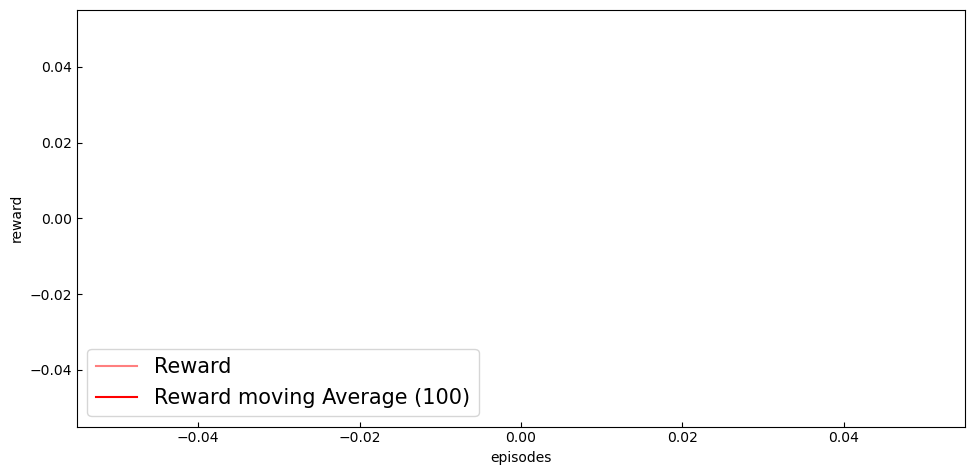

In [ ]:
# 値の推移をプロット
plt.figure(figsize=(10, 5))
plt.plot(sum_reward, label="Reward", color="red", alpha=0.5)


# 移動平均の推移を計算してプロット
window_size = 100  # 移動平均の窓サイズ

# リストをarrayに変換
arr = np.array(sum_reward)

# 移動平均を計算
kernel = np.ones(window_size) / window_size
rolling_mean = np.convolve(arr, kernel, mode='valid')

plt.plot(rolling_mean, label=f"Reward moving Average ({window_size})", color="red")
plt.rcParams["font.size"] = 15
# グラフのタイトルとラベル
# plt.title('Value Transition and Moving Average')
plt.xlabel("episodes")
plt.ylabel("reward")
plt.legend(loc='lower left')

# グラフを表示
plt.tick_params(direction='in')  # 目盛りを内側にする
plt.tight_layout()  # レイアウトを調整して重なりを避ける
plt.show()

# Save model

In [ ]:
# model_dir = 'model'
# os.makedirs(model_dir, exist_ok=True)
# torch.save(net.state_dict(), './model/model13.pth')

# load model weight

In [ ]:
# model = CNNQNetwork(env.observation_space.shape, n_action=env.action_space.n)
# model.load_state_dict(torch.load('load/from/path/model.pth'))